# Implementation of Linear Hard Margin SVMs through CRNs

We shall be implementing linear hard margin SVMs using CRNs

In [19]:
# Format of notebook:
# Give a diagram and explaination of the network
# importing libraries
# defining the helper function
# training
# plotting
# testing
# plotting 


In [20]:
# Give Diagram and explaination of the network, also explain some of the functions used in the network

In [21]:
# importing libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [22]:
# oscillator wrapper function takes in an array of oscillating species names, array of doped species, current timestep
# a dictionary containing all the species concentrations, and an output dictionary for current timestep

def oscillator_function(y,t,num_oscillating_species):
    # making the array of the oscillating species
    oscillating_species = y[0:num_oscillating_species]
    doped_species = y[num_oscillating_species:]

    num_doped_species = len(doped_species)

    # initialisinng the derivatives
    d_oscillating_species = np.zeros(num_oscillating_species)
    d_doped_species = np.zeros(num_doped_species)

    # defining the derivatives 

    # for the oscillating species
    d_oscillating_species[0] = -oscillating_species[0]*oscillating_species[1] + oscillating_species[num_oscillating_species-1]*oscillating_species[0] + doped_species[0]*oscillating_species[num_oscillating_species-1] - doped_species[1]*oscillating_species[0]

    for idx in range(1,num_oscillating_species-1):
        d_oscillating_species[idx] = oscillating_species[idx-1]*oscillating_species[idx] - oscillating_species[idx+1]*oscillating_species[idx] + doped_species[idx]*oscillating_species[idx-1] - doped_species[idx+1]*oscillating_species[idx]
    
    d_oscillating_species[num_oscillating_species-1] = oscillating_species[num_oscillating_species-2]*oscillating_species[num_oscillating_species-1] - oscillating_species[0]*oscillating_species[num_oscillating_species-1] + doped_species[num_doped_species-1]*oscillating_species[num_oscillating_species-2] - doped_species[0]*oscillating_species[num_oscillating_species-1]

    # for the doped species
    d_doped_species[0] = -doped_species[0]*oscillating_species[num_doped_species-1]

    for idx in range(1,num_doped_species):
        d_doped_species[idx] = -doped_species[idx]*oscillating_species[idx-1]
    
    dydt = []
    dydt.extend(d_oscillating_species)
    dydt.extend(d_doped_species)
    
    return dydt

def oscillator_wrapper(oscillating_species, doped_species, current_timestep, species_concentrations, species_concentrations_current_timestep):
    
    # making an array of the species concentrations at timestep: current_timestep - 1
    oscillating_species_concentrations = np.array([species_concentrations[species][current_timestep - 1] for species in oscillating_species])
    doped_species_concentrations = np.array([species_concentrations[species][current_timestep - 1] for species in doped_species])

    # number of oscillating species 
    num_oscillating_species = len(oscillating_species_concentrations)

    # making the input array for the oscillator function
    y_0 = []
    y_0.extend(oscillating_species_concentrations)
    y_0.extend(doped_species_concentrations)

    # calculating the time range
    t = np.linspace(current_timestep - 1, current_timestep, 2) # 2 steps

    # solving the ODE
    sol = odeint(oscillator_function, y_0, t, args=(num_oscillating_species,))

    # updating the species concentrations in current timestep
    for idx, species in enumerate(oscillating_species):
        species_concentrations_current_timestep[species] = sol[1][idx]

    for idx, species in enumerate(doped_species):
        species_concentrations_current_timestep[species] = sol[1][num_oscillating_species + idx]

    return species_concentrations_current_timestep





In [23]:
threshold = 0.0001

In [24]:
# laoding function
def load_function(y,t,a, o):
    c = y[0]
    dc_dt = -c*o + a*o
    return [ dc_dt]

def load_wrapper(from_species, to_species, regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep):

    # getting the species concentrations at current timestep - 1
    from_species_concentration = species_concentrations[from_species][current_timestep - 1]
    to_species_concentration = species_concentrations[to_species][current_timestep - 1]
    regulating_species_concentration = species_concentrations[regulating_species][current_timestep - 1]

    y0 = [to_species_concentration]
    t = np.linspace(current_timestep - 1, current_timestep, 2) # 2 steps
    
    sol = odeint(load_function, y0, t, args=(from_species_concentration, regulating_species_concentration))

    if np.abs(sol[1][0] - to_species_concentration) > threshold: # to ensure update only happens when substantial #review
        species_concentrations_current_timestep[to_species] = sol[1][0] # only value of to_species is updated

    return species_concentrations_current_timestep



In [25]:
# multiplication function
def product_f(y,t,multiplicand_species_concentrations,o):
    c = y[0]

    dc_dt = 0

    temp = 1
    for idx, multiplicand in enumerate(multiplicand_species_concentrations):
        temp  = temp * multiplicand
    
    dc_dt = -c*o + temp*o
    return [ dc_dt]

def product_wrapper(multiplicand_species, product,regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep):

    multiplicand_species_concentrations = np.array([species_concentrations[species][current_timestep - 1] for species in multiplicand_species])

    c = species_concentrations[product][current_timestep - 1]
    o = species_concentrations[regulating_species][current_timestep - 1]

    y0 = [c]
    t = np.linspace(current_timestep-1, current_timestep,2)
    
    sol = odeint(product_f, y0, t, args=(multiplicand_species_concentrations, o))

    if np.abs(c-sol[1][0])> threshold:
        species_concentrations_current_timestep[product] = sol[1][0]

    return species_concentrations_current_timestep

In [26]:
# sum function
def sum_f(y,t,additive_species_concentrations,o):
    c = y[0]
    temp =0
    for idx, additive in enumerate(additive_species_concentrations):
        temp = temp + additive
    dc_dt = -c*o + temp*o
    return [ dc_dt]

def sum_wrapper(additive_species, sum, regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep):

    # getting the species concentrations at current timestep -1
    additive_species_concentrations =  np.array([species_concentrations[species][current_timestep - 1] for species in additive_species])

    c = species_concentrations[sum][current_timestep-1]
    o = species_concentrations[regulating_species][current_timestep-1]

    y0 = [c]
    t = np.linspace(current_timestep-1, current_timestep,2)
    
    sol = odeint(sum_f, y0, t, args=(additive_species_concentrations,o))

    if np.abs(c-sol[1][0]) > threshold:
        species_concentrations_current_timestep[sum] = sol[1][0]

    return species_concentrations_current_timestep

In [27]:
# mapping function for comparison
def comparison_f(y, t, a, b, o):
    dydt = []
    bgta = y[0]
    blta = y[1]

    temp = b*blta*o - bgta*a*o
    dydt.append(temp)

    temp = bgta*a*o - b*blta*o
    dydt.append(temp)

    return dydt

def comparison_wrapper(species_a,species_b, b_gt_a, b_lt_a, regulating_species , current_timestep, species_concentrations, species_concentrations_current_timestep):

    a = species_concentrations[species_a][current_timestep-1]
    b = species_concentrations[species_b][current_timestep-1]
    bgta = species_concentrations[b_gt_a][current_timestep-1]
    blta = species_concentrations[b_lt_a][current_timestep-1]
    o = species_concentrations[regulating_species][current_timestep-1]

    y0 = [bgta, blta]
    t = np.linspace(current_timestep -1, current_timestep, 2)
    
    sol = odeint(comparison_f, y0, t, args=(a,b, o))

    if np.abs(bgta-sol[:,0][-1]) > threshold:
        species_concentrations_current_timestep[b_gt_a] = sol[:, 0][-1]
    if np.abs(blta-sol[:,1][-1]) > threshold:
        species_concentrations_current_timestep[b_lt_a] = sol[:, 1][-1]

    return species_concentrations_current_timestep


In [28]:
# approximate majority for comparison
def approx_majority_f(y, t, o):
    kgtq = y[0]
    kltq = y[1]
    b_help = y[2]

    dydt = []
    
    temp =  - kgtq*kltq*o + kgtq *b_help*o
    dydt.append(temp)

    temp = kltq*b_help*o - kgtq*kltq*o
    dydt.append(temp)

    temp = 2* kgtq*kltq*o - kgtq*b_help*o - kltq*b_help*o
    dydt.append(temp)

    return dydt

def approx_majority_wrapper(b_gt_a, b_lt_a, helper_species, regulating_species, current_timestep, species_concentrations, species_concentrations_current_timestep):

    bgta = species_concentrations[b_gt_a][current_timestep-1]
    blta = species_concentrations[b_lt_a][current_timestep-1]
    helper_s = species_concentrations[helper_species][current_timestep-1]
    o = species_concentrations[regulating_species][current_timestep-1]

    y_0 = [bgta, blta, helper_s]

    t = np.linspace(current_timestep, current_timestep+1, 2)

    sol = odeint(approx_majority_f, y_0, t, args=(o,))

    if np.abs(bgta-sol[:,0][-1]) > threshold:
        species_concentrations_current_timestep[b_gt_a] = sol[:, 0][-1]
    if np.abs(blta-sol[:,1][-1]) > threshold:
        species_concentrations_current_timestep[b_lt_a] = sol[:, 1][-1]
    if np.abs(helper_s - sol[:,2][-1]) > threshold:
        species_concentrations_current_timestep[helper_species] = sol[:,2][-1]

    return species_concentrations_current_timestep


In [29]:
# making the dataset for train ( same as above )
X = np.array([[1, 7], [2, 8], [3, 8], [5, 1], [6, -1], [7, 3]])
y = np.array([1, 1, 1, -1, -1, -1])

In [30]:
# function for dual_rail encoding
def dual_rail_encoding(X):
    X_p = []
    X_n = []

    for x in X:
        # if x is an array of elements
        if isinstance(x, np.ndarray):
            x_p = []
            x_n = []
            for ele in x:
                if ele >0 :
                    x_p.append(ele)
                    x_n.append(0)
                else:
                    x_p.append(0)
                    x_n.append(-1*ele)
            X_p.append(x_p)
            X_n.append(x_n)

        else:
            if x >0:
                X_p.append(x)
                X_n.append(0)
            else:
                X_p.append(0)
                X_n.append(-1*x)

    return X_p, X_n


In [31]:
X_p, X_n = dual_rail_encoding(X)    
Y_p, Y_n = dual_rail_encoding(y)

In [32]:
# training :
# input loading
# W_X = W * X
# P = summation of W_X + B
# Q = YP
# Comparison of Q with 1 
# Update steps


In [33]:
# time_limit = 10000


# for t in range(time_limit):
#     # module for loading input

#     # 

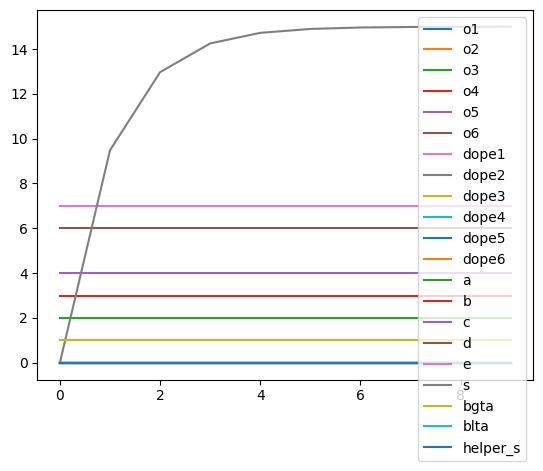

1


In [37]:
# initialisation
d = 10 **(-10)
species_concentrations = {
    'o1': [1],
    'o2': [0],
    'o3': [0],
    'o4': [0],
    'o5': [0],
    'o6': [0],
    'dope1': [d],
    'dope2': [d],
    'dope3': [d],
    'dope4': [d],
    'dope5': [d],
    'dope6': [d],
    'a' : [2],
    'b' : [3],
    'c' : [4],
    'd' : [6],
    'e' : [7],
    's' :[0],
    'bgta': [1],
    'blta': [ 0],
    'helper_s': [0]
}
ti=1
# osc = ['o1', 'o2','o3', 'o4']
# dop = ['dope1', 'dope2', 'dope3', 'dope4']
osc = ['o1', 'o2','o3', 'o4','o5', 'o6']
dop = ['dope1', 'dope2', 'dope3', 'dope4', 'dope5', 'dope6']

for t in range(1, 10):
    # Get updated concentrations for the current timestep
    updated_concentrations_current_t = oscillator_wrapper(osc, dop, t, species_concentrations, {})
    # updated_concentrations_current_t = product_wrapper('a','c','b' ,'o3', t, species_concentrations,updated_concentrations_current_t )
    # updated_concentrations_current_t = load_wrapper('a', 'c', 'o1', t, species_concentrations,updated_concentrations_current_t )
    updated_concentrations_current_t = sum_wrapper(['a','b', 'c', 'd'],'s', 'o1', t,species_concentrations, updated_concentrations_current_t )
    # updated_concentrations_current_t = sum_wrapper('d','c','s', 'o1', t,species_concentrations, updated_concentrations_current_t )
    # updated_concentrations_current_t = sum_wrapper('a','d','s', 'o1', t,species_concentrations, updated_concentrations_current_t )
    # updated_concentrations_current_t = sum_wrapper('a','e','s', 'o1', t,species_concentrations, updated_concentrations_current_t )
    # updated_concentrations_current_t = product_wrapper('a','c', 'b', 'o1', t, species_concentrations, updated_concentrations_current_t)

    # updated_concentrations_current_t = approx_majority_wrapper('bgta', 'blta', 'helper_s', 'o3', t, species_concentrations, updated_concentrations_current_t)
    # updated_concentrations_current_t = comparison_wrapper('a','b', 'bgta','blta', 'o1', t, species_concentrations, updated_concentrations_current_t)
    
    # Update the species_concentrations dictionary with the new concentrations
    for species in species_concentrations:
        if species in updated_concentrations_current_t:
            species_concentrations[species].append(updated_concentrations_current_t[species])
        else:
            species_concentrations[species].append(species_concentrations[species][t-1])
     
# plotting the  species in the species_concentrations dictionary
for species in species_concentrations:
    # if species == 'a'or species == 'b' or species == 'c':
     plt.plot(species_concentrations[species], label=species)
plt.legend()
plt.show()

print(species_concentrations['bgta'][-1] + species_concentrations['blta'][-1])


In [ ]:
# # trying out this function
# osc = ['o1', 'o2','o3']
# dop = ['dope1', 'dope2', 'dope3']

# d = 10 **(-15)
# species_concentrations = {
#     'o1': [1],
#     'o2': [0],
#     'o3': [0],
#     'dope1': [d],
#     'dope2': [d],
#     'dope3': [d]
# }


# for t in range(1, 100):
#     # Get updated concentrations for the current timestep
#     updated_concentrations = oscillator_wrapper(osc, dop, t, species_concentrations, {})
    
#     # Update the species_concentrations dictionary with the new concentrations
#     for species in updated_concentrations:
#         species_concentrations[species].append(updated_concentrations[species])

# # print(species_concentrations)

# # plotting the  species in the species_concentrations dictionary
# for species in species_concentrations:
#     plt.plot(species_concentrations[species], label=species)

# plt.legend()
# plt.show()


# d = 10 **(-10)
# species_concentrations = {
#     'o1': [1],
#     'o2': [0],
#     'o3': [0],
#     'o4': [0],
#     'dope1': [d],
#     'dope2': [d],
#     'dope3': [d],
#     'dope4': [d],
#     'a' : [2],
#     'b' : [3],
#     'c' : [4]
# }

# osc = ['o1', 'o2','o3', 'o4']
# dop = ['dope1', 'dope2', 'dope3', 'dope4']

# for t in range(1, 1000):
#     # Get updated concentrations for the current timestep
#     updated_concentrations_osc = oscillator_wrapper(osc, dop, t, species_concentrations, {})
#     updated_concentrations_load = load_wrapper('a', 'c', 'o1', t, species_concentrations,updated_concentrations_osc )
#     updated_concentrations_load = load_wrapper('b', 'a', 'o4', t, species_concentrations,updated_concentrations_load )
    
#     # Update the species_concentrations dictionary with the new concentrations
#     for species in updated_concentrations_load:
#         species_concentrations[species].append(updated_concentrations_load[species])

# # plotting the  species in the species_concentrations dictionary
# for species in species_concentrations:
#     plt.plot(species_concentrations[species], label=species)
# plt.legend()
# plt.show()


In [ ]:
# Questions to ask:
# 1. We need to ensure that every module finishes in its first oscillation (i think), so make a new network with not all oscillating
# 2. as doing odeint for basically 1 step, do  i really need to do it? can simply do x_t = x_t-1 + dxdt?
# 3. between oscillations, the transition causes change in concentration of other species Answer: space by 2 oscillations , o1 ,o2, then o3 and also introduce o4
# 4. Different species for read and write (not LHS and RHS in species)
# 5. jumled order of instructions forces us to include change threshold update. do u want that?


# Things to do:
# 1. formalise the notebook, by adding markdowns
# 2. check reviews once
